## Classify MNIST with MLP

### [2024.04.05] 이상혁

### 개요
- 처음에 GPU가 잘 작동하는지 확인하기 위해 사용했던 MNSIT 데이터를 사용하여 Custom MLP를 설계
- 이때 기존 신경망 설계에서는 잘 사용하지 않았던 기법도 사용해보기 위해 시도

### 0. GPU Configuration

💻빠른 연산을 위해 PyTorch에서 **GPU**를 사용할 수 있도록 설정해준다.

In [1]:
# 커널 충돌 방지
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# kernel 충돌로 matplotlib.pyplot가 그려지지 않을 때 해결 방법 -> 환경 변수를 설정
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# 시드 고정
SEED = 405

if device == 'cuda':
    torch.cuda.manual_seed_all(SEED)
else:
    torch.manual_seed(SEED)

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import random
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from torchsummary import summary

In [5]:
os.chdir('C:/Python_Programs/Pytorch/6. MNIST')

### 1. Download Datasets

데이터셋은 torchvision에서 제공하는 MNIST 데이터셋이다.

In [6]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 학습용 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

불러온 데이터를 확인해보기 위해 일부를 시각화해보자.

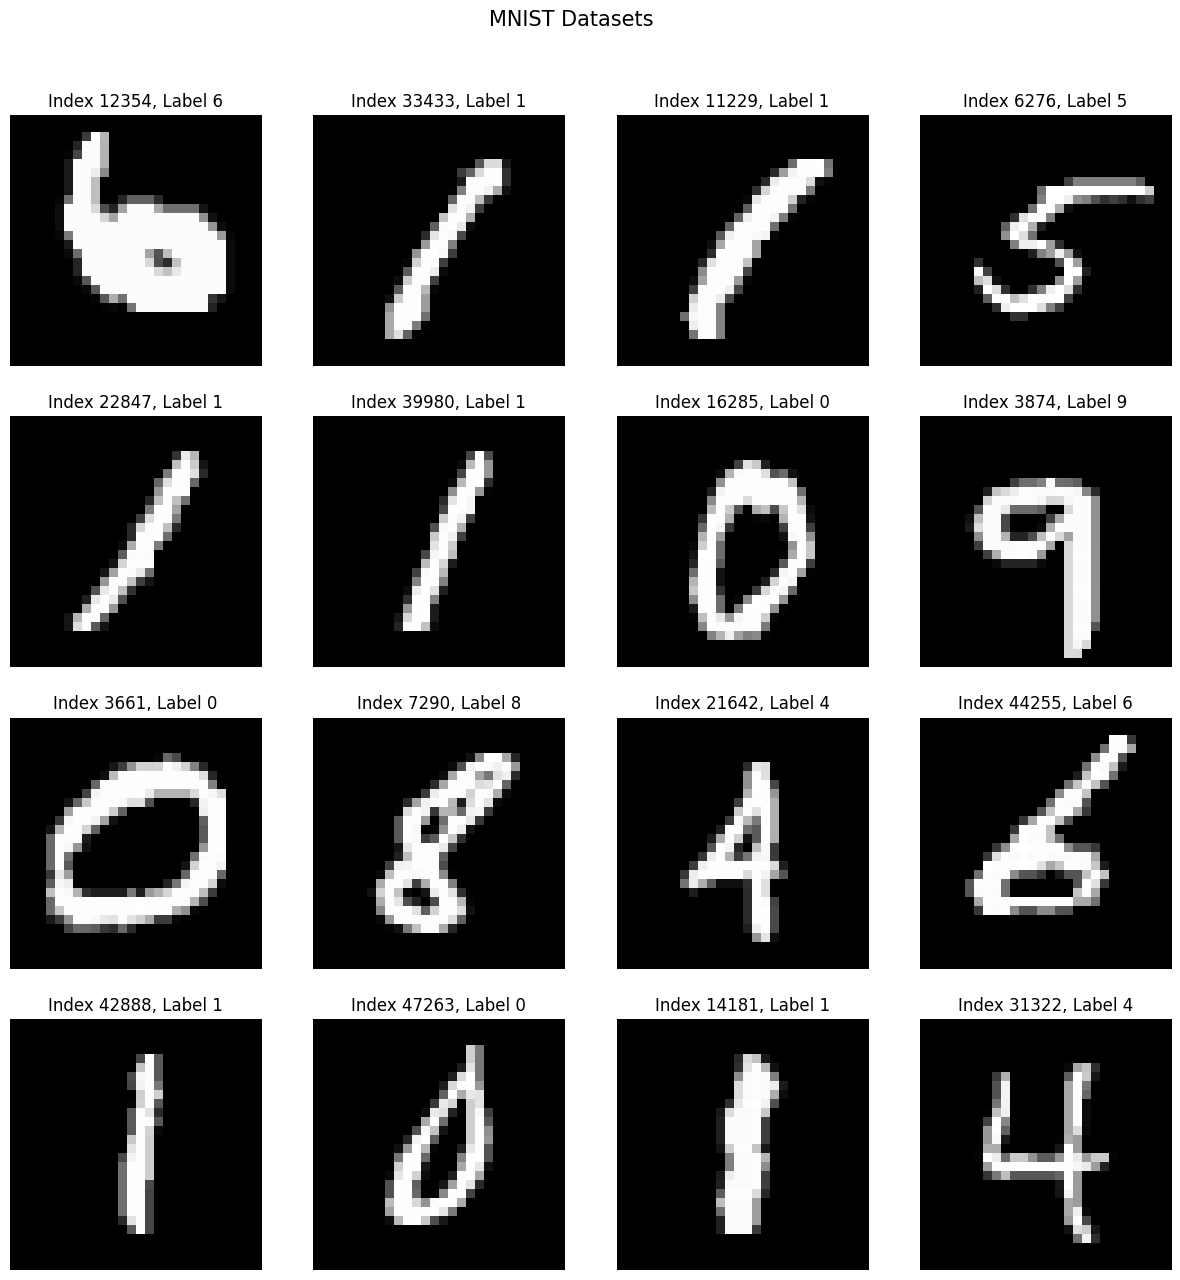

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

axes = axes.flatten() # numpy 형식과 맞추기 위함

for i in range(16):
    sample = random.randint(0, len(mnist_train) - 1) # 0부터 len(mnist_train) 사이에서 무작위로 정수 하나를 선택
    image, label = mnist_train[sample]
    axes[i].imshow(image.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f'Index {sample}, Label {label}')
    axes[i].axis("off")

plt.suptitle('MNIST Datasets', fontsize = 15, y=0.95)
plt.show()

위 그림을 학습해서 레이블을 예측하는 문제를 해결해보자.

학습 과정을 validation 데이터로 평가하기 위해 별도로 검증 데이터셋을 정의하자.
- ```torch.utils.data.Subset```과 ```torch.utils.data.random_split```을 사용하면 쉽게 분류할 수 있다.

In [8]:
len(mnist_train)

60000

60,000개의 데이터셋이 있기 때문에, 7:3 비율인 42,000개와 18,000개로 분리하자.

In [8]:
train_size = 42000
val_size = 18000

# 데이터셋 분리
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

데이터셋을 잘 분할했다. 이제 데이터셋을 데이터로더로 정의하자.

In [9]:
# 학습용 데이터로더
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=128,
                              shuffle=True,
                              drop_last=True)

# 검증용 데이터로더
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=128,
                            shuffle=True,
                            drop_last=True)

# 평가용 데이터로더
test_dataloader = DataLoader(dataset=mnist_test,
                             batch_size=128,
                             shuffle=True,
                             drop_last=True)

❗ 여기서 하나 참고
- ```len(train_dataloader)=328```이고, ```batch_size=128```이다.
- 따라서 ```328*128 = 41984```인데 ```len(train_dataset) = 42000```과 약간 차이가 있다.
- 이는 데이터셋을 데이터로더로 정의하면서 배치 크기 단위로 데이터로더를 나누면서 약간의 오차가 발생한다.
- 이때 ```drop_last=True```로 인해 나머지는 없어진 것이다! 오류가 아니니 걱정말자.

### 2. Model Training

가장 먼저 학습과 검증을 진행하기 위한 함수를 정의하자.
- loss 함수는 ```CrossEntropyLoss```를 사용하게 될 것 같다.
    - 손실함수 자체에 소프트맥스가 포함되어 있기 때문에 따로 모델의 출력값을 수정할 필요가 없다.
- Metric은 ```Accuracy```를 사용하게 될 것 같다.
    - ```torchmetrics```를 사용하면 쉽다.
    - 이때 multiclass 분류 문제인 점을 고려해야 한다.
    - [링크](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html)를 참고하자.

In [10]:
def train_model(model, train_dataloader, criterion, optimizer, metric, device):
    model.train() # 모델을 학습 모드로 전환
    
    train_loss = 0
    train_acc = 0

    for x, y in tqdm(train_dataloader, desc = 'Training'):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # metric 계산
        train_acc += metric(outputs, y).item()

    return train_loss / len(train_dataloader), train_acc / len(train_dataloader)

In [11]:
def valid_model(model, valid_dataloader, criterion, metric, device): # 역전파를 진행하지 않기 떄문에 옵티마이저 필요 없음
    model.eval() # 모델을 평가 모드로 전환

    valid_loss = 0
    valid_acc = 0

    for x, y in tqdm(valid_dataloader, desc='Validation'):
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad(): # Gradient 계산을 비활성화
            outputs = model(x)
            loss = criterion(outputs, y)
        
        valid_loss += loss.item()
        
        # metric 계산
        valid_acc += metric(outputs, y).item()

    return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader)

In [12]:
def model_training(model, train_dataloader, valid_dataloader, criterion, optimizer, metric, device, num_epochs, wait_for_es):
    train_loss_history, train_acc_history = [], [] # 훈련 과정 기록
    valid_loss_history, valid_acc_history = [], [] # 평가 과정 기록

    # 조기 종료를 위한 조건 설정
    best_loss = 10 ** 5
    count = 0

    # 가장 성능이 좋은 모델을 저장하기 위한 조건
    best_acc = 0

    # 경과 시간 기록 시작
    start_time = time.time() 

    for epoch in range(num_epochs):
        print('-'*80)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-'*80)

        train_loss, train_acc = train_model(model, train_dataloader, criterion, optimizer, metric, device) # 학습용 데이터로더로부터 학습
        valid_loss, valid_acc = valid_model(model, valid_dataloader, criterion, metric, device) # 평가용 데이터로더로부터 평가


        # 매 epoch마다 학습 기록 저장
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # 매 epoch마다 평가 기록 저장
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # 경과 종료 시간 기록
        end_time = time.time()

        # 총 걸린 시간
        elapsed_time = end_time - start_time
        
        print('[Train]\t Loss: {:.4f} \t Acc: {:.4f}'.format(train_loss, train_acc))
        print('[Valid]\t Loss: {:.4f} \t Acc: {:.4f}'.format(valid_loss, valid_acc))
        print('(Epoch {} complete in {:.0f}m {:.0f}s)'.format(epoch+1, elapsed_time // 60, elapsed_time % 60))

        # 성능이 좋은 모델 저장
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), './models/MNIST_CNN' + str(epoch+1) + '.pth')

        # 조기종료 조건 확인
        if valid_loss < best_loss:
            best_loss = valid_loss
        else:
            count += 1

            if count >= wait_for_es:
                print('-----<Early Stopping at Epoch {}>-----'.format(str(epoch + 1)))
                break

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

### 3. Model

#### 3-1. First Model

가장 기본적인 CNN 모델을 사용하자.

In [14]:
class MNIST_CNN(nn.Module):

    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # 첫번째층
        # Input = (?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # Input = (?, 14, 14, 32)
        # Conv -> (?, 14, 14, 64)
        # Pool -> (?, 7, 7, 64)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = nn.Linear(7 * 7 * 64, 10, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 1차원으로 Flatten
        out = self.fc(out)
        return out

In [15]:
# 모델 정의
model = MNIST_CNN()
model.to(device)

MNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [16]:
# 모델 파라미터 개수 확인
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 0.19
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [17]:
# trainable parameter 확인 방법
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 50,186 trainable parameters


In [20]:
# 옵티마이저, 손실함수, 평가함수 정의
optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)
acc_metric = Accuracy(task="multiclass", num_classes=10).to(device) # num_classes: 0~9

In [21]:
# 파라미터 정의
num_epochs = 100
wait_for_es = 10

In [22]:
# 모델 학습
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = model_training(model, 
                                                                                              train_dataloader, 
                                                                                              val_dataloader, 
                                                                                              criterion, 
                                                                                              optimizer, 
                                                                                              acc_metric, 
                                                                                              device, 
                                                                                              num_epochs, 
                                                                                              wait_for_es)

--------------------------------------------------------------------------------
Epoch 1/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:03<00:00, 41.69it/s]


[Train]	 Loss: 2.2535 	 Acc: 0.2596
[Valid]	 Loss: 2.2067 	 Acc: 0.4307
(Epoch 1 complete in 0m 22s)
--------------------------------------------------------------------------------
Epoch 2/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 31.01it/s]


[Train]	 Loss: 2.1354 	 Acc: 0.5855
[Valid]	 Loss: 2.0550 	 Acc: 0.6752
(Epoch 2 complete in 0m 43s)
--------------------------------------------------------------------------------
Epoch 3/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.97it/s]


[Train]	 Loss: 1.9192 	 Acc: 0.7171
[Valid]	 Loss: 1.7634 	 Acc: 0.7352
(Epoch 3 complete in 1m 4s)
--------------------------------------------------------------------------------
Epoch 4/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.71it/s]


[Train]	 Loss: 1.5394 	 Acc: 0.7544
[Valid]	 Loss: 1.3164 	 Acc: 0.7677
(Epoch 4 complete in 1m 26s)
--------------------------------------------------------------------------------
Epoch 5/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.02it/s]


[Train]	 Loss: 1.1049 	 Acc: 0.7834
[Valid]	 Loss: 0.9389 	 Acc: 0.7968
(Epoch 5 complete in 1m 47s)
--------------------------------------------------------------------------------
Epoch 6/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.30it/s]


[Train]	 Loss: 0.8151 	 Acc: 0.8102
[Valid]	 Loss: 0.7281 	 Acc: 0.8237
(Epoch 6 complete in 2m 8s)
--------------------------------------------------------------------------------
Epoch 7/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.88it/s]


[Train]	 Loss: 0.6571 	 Acc: 0.8326
[Valid]	 Loss: 0.6101 	 Acc: 0.8424
(Epoch 7 complete in 2m 29s)
--------------------------------------------------------------------------------
Epoch 8/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.13it/s]


[Train]	 Loss: 0.5653 	 Acc: 0.8500
[Valid]	 Loss: 0.5409 	 Acc: 0.8568
(Epoch 8 complete in 2m 50s)
--------------------------------------------------------------------------------
Epoch 9/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.88it/s]


[Train]	 Loss: 0.5066 	 Acc: 0.8621
[Valid]	 Loss: 0.4942 	 Acc: 0.8644
(Epoch 9 complete in 3m 12s)
--------------------------------------------------------------------------------
Epoch 10/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.11it/s]


[Train]	 Loss: 0.4662 	 Acc: 0.8700
[Valid]	 Loss: 0.4578 	 Acc: 0.8757
(Epoch 10 complete in 3m 33s)
--------------------------------------------------------------------------------
Epoch 11/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.90it/s]


[Train]	 Loss: 0.4367 	 Acc: 0.8770
[Valid]	 Loss: 0.4319 	 Acc: 0.8801
(Epoch 11 complete in 3m 54s)
--------------------------------------------------------------------------------
Epoch 12/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.12it/s]


[Train]	 Loss: 0.4139 	 Acc: 0.8825
[Valid]	 Loss: 0.4117 	 Acc: 0.8857
(Epoch 12 complete in 4m 16s)
--------------------------------------------------------------------------------
Epoch 13/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.85it/s]


[Train]	 Loss: 0.3957 	 Acc: 0.8869
[Valid]	 Loss: 0.3976 	 Acc: 0.8885
(Epoch 13 complete in 4m 37s)
--------------------------------------------------------------------------------
Epoch 14/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.13it/s]


[Train]	 Loss: 0.3809 	 Acc: 0.8908
[Valid]	 Loss: 0.3843 	 Acc: 0.8911
(Epoch 14 complete in 4m 58s)
--------------------------------------------------------------------------------
Epoch 15/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.54it/s]


[Train]	 Loss: 0.3682 	 Acc: 0.8936
[Valid]	 Loss: 0.3727 	 Acc: 0.8935
(Epoch 15 complete in 5m 21s)
--------------------------------------------------------------------------------
Epoch 16/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.04it/s]


[Train]	 Loss: 0.3574 	 Acc: 0.8970
[Valid]	 Loss: 0.3613 	 Acc: 0.8978
(Epoch 16 complete in 5m 43s)
--------------------------------------------------------------------------------
Epoch 17/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.78it/s]


[Train]	 Loss: 0.3479 	 Acc: 0.8993
[Valid]	 Loss: 0.3521 	 Acc: 0.8996
(Epoch 17 complete in 6m 5s)
--------------------------------------------------------------------------------
Epoch 18/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.36it/s]


[Train]	 Loss: 0.3394 	 Acc: 0.9012
[Valid]	 Loss: 0.3452 	 Acc: 0.9026
(Epoch 18 complete in 6m 26s)
--------------------------------------------------------------------------------
Epoch 19/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.98it/s]


[Train]	 Loss: 0.3317 	 Acc: 0.9035
[Valid]	 Loss: 0.3396 	 Acc: 0.9040
(Epoch 19 complete in 6m 46s)
--------------------------------------------------------------------------------
Epoch 20/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.49it/s]


[Train]	 Loss: 0.3248 	 Acc: 0.9054
[Valid]	 Loss: 0.3322 	 Acc: 0.9047
(Epoch 20 complete in 7m 7s)
--------------------------------------------------------------------------------
Epoch 21/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:05<00:00, 24.12it/s]


[Train]	 Loss: 0.3183 	 Acc: 0.9074
[Valid]	 Loss: 0.3256 	 Acc: 0.9055
(Epoch 21 complete in 7m 31s)
--------------------------------------------------------------------------------
Epoch 22/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 31.53it/s]


[Train]	 Loss: 0.3127 	 Acc: 0.9084
[Valid]	 Loss: 0.3200 	 Acc: 0.9071
(Epoch 22 complete in 7m 50s)
--------------------------------------------------------------------------------
Epoch 23/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.62it/s]


[Train]	 Loss: 0.3072 	 Acc: 0.9101
[Valid]	 Loss: 0.3158 	 Acc: 0.9084
(Epoch 23 complete in 8m 11s)
--------------------------------------------------------------------------------
Epoch 24/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.94it/s]


[Train]	 Loss: 0.3022 	 Acc: 0.9119
[Valid]	 Loss: 0.3112 	 Acc: 0.9097
(Epoch 24 complete in 8m 32s)
--------------------------------------------------------------------------------
Epoch 25/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.55it/s]


[Train]	 Loss: 0.2972 	 Acc: 0.9137
[Valid]	 Loss: 0.3055 	 Acc: 0.9112
(Epoch 25 complete in 8m 55s)
--------------------------------------------------------------------------------
Epoch 26/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.66it/s]


[Train]	 Loss: 0.2927 	 Acc: 0.9151
[Valid]	 Loss: 0.3014 	 Acc: 0.9131
(Epoch 26 complete in 9m 19s)
--------------------------------------------------------------------------------
Epoch 27/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 31.78it/s]


[Train]	 Loss: 0.2883 	 Acc: 0.9160
[Valid]	 Loss: 0.2966 	 Acc: 0.9140
(Epoch 27 complete in 9m 38s)
--------------------------------------------------------------------------------
Epoch 28/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 29.61it/s]


[Train]	 Loss: 0.2842 	 Acc: 0.9168
[Valid]	 Loss: 0.2932 	 Acc: 0.9148
(Epoch 28 complete in 10m 1s)
--------------------------------------------------------------------------------
Epoch 29/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 31.31it/s]


[Train]	 Loss: 0.2802 	 Acc: 0.9179
[Valid]	 Loss: 0.2889 	 Acc: 0.9169
(Epoch 29 complete in 10m 24s)
--------------------------------------------------------------------------------
Epoch 30/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.55it/s]


[Train]	 Loss: 0.2763 	 Acc: 0.9188
[Valid]	 Loss: 0.2858 	 Acc: 0.9179
(Epoch 30 complete in 10m 45s)
--------------------------------------------------------------------------------
Epoch 31/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 28.97it/s]


[Train]	 Loss: 0.2723 	 Acc: 0.9208
[Valid]	 Loss: 0.2842 	 Acc: 0.9169
(Epoch 31 complete in 11m 7s)
--------------------------------------------------------------------------------
Epoch 32/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.01it/s]


[Train]	 Loss: 0.2690 	 Acc: 0.9209
[Valid]	 Loss: 0.2794 	 Acc: 0.9191
(Epoch 32 complete in 11m 29s)
--------------------------------------------------------------------------------
Epoch 33/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.96it/s]


[Train]	 Loss: 0.2655 	 Acc: 0.9230
[Valid]	 Loss: 0.2758 	 Acc: 0.9201
(Epoch 33 complete in 11m 51s)
--------------------------------------------------------------------------------
Epoch 34/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 28.16it/s]


[Train]	 Loss: 0.2622 	 Acc: 0.9234
[Valid]	 Loss: 0.2723 	 Acc: 0.9217
(Epoch 34 complete in 12m 14s)
--------------------------------------------------------------------------------
Epoch 35/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.68it/s]


[Train]	 Loss: 0.2587 	 Acc: 0.9251
[Valid]	 Loss: 0.2694 	 Acc: 0.9214
(Epoch 35 complete in 12m 36s)
--------------------------------------------------------------------------------
Epoch 36/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.47it/s]


[Train]	 Loss: 0.2556 	 Acc: 0.9251
[Valid]	 Loss: 0.2688 	 Acc: 0.9220
(Epoch 36 complete in 12m 58s)
--------------------------------------------------------------------------------
Epoch 37/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.13it/s]


[Train]	 Loss: 0.2523 	 Acc: 0.9263
[Valid]	 Loss: 0.2643 	 Acc: 0.9227
(Epoch 37 complete in 13m 20s)
--------------------------------------------------------------------------------
Epoch 38/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.94it/s]


[Train]	 Loss: 0.2489 	 Acc: 0.9275
[Valid]	 Loss: 0.2607 	 Acc: 0.9244
(Epoch 38 complete in 13m 40s)
--------------------------------------------------------------------------------
Epoch 39/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.46it/s]


[Train]	 Loss: 0.2463 	 Acc: 0.9281
[Valid]	 Loss: 0.2562 	 Acc: 0.9249
(Epoch 39 complete in 14m 0s)
--------------------------------------------------------------------------------
Epoch 40/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.28it/s]


[Train]	 Loss: 0.2433 	 Acc: 0.9284
[Valid]	 Loss: 0.2541 	 Acc: 0.9264
(Epoch 40 complete in 14m 21s)
--------------------------------------------------------------------------------
Epoch 41/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.98it/s]


[Train]	 Loss: 0.2405 	 Acc: 0.9299
[Valid]	 Loss: 0.2509 	 Acc: 0.9267
(Epoch 41 complete in 14m 41s)
--------------------------------------------------------------------------------
Epoch 42/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.37it/s]


[Train]	 Loss: 0.2373 	 Acc: 0.9302
[Valid]	 Loss: 0.2500 	 Acc: 0.9277
(Epoch 42 complete in 15m 2s)
--------------------------------------------------------------------------------
Epoch 43/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.94it/s]


[Train]	 Loss: 0.2348 	 Acc: 0.9314
[Valid]	 Loss: 0.2450 	 Acc: 0.9294
(Epoch 43 complete in 15m 23s)
--------------------------------------------------------------------------------
Epoch 44/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.35it/s]


[Train]	 Loss: 0.2318 	 Acc: 0.9323
[Valid]	 Loss: 0.2434 	 Acc: 0.9304
(Epoch 44 complete in 15m 43s)
--------------------------------------------------------------------------------
Epoch 45/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.93it/s]


[Train]	 Loss: 0.2292 	 Acc: 0.9328
[Valid]	 Loss: 0.2418 	 Acc: 0.9297
(Epoch 45 complete in 16m 3s)
--------------------------------------------------------------------------------
Epoch 46/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.82it/s]


[Train]	 Loss: 0.2267 	 Acc: 0.9337
[Valid]	 Loss: 0.2386 	 Acc: 0.9308
(Epoch 46 complete in 16m 23s)
--------------------------------------------------------------------------------
Epoch 47/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.20it/s]


[Train]	 Loss: 0.2240 	 Acc: 0.9345
[Valid]	 Loss: 0.2350 	 Acc: 0.9324
(Epoch 47 complete in 16m 44s)
--------------------------------------------------------------------------------
Epoch 48/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 31.66it/s]


[Train]	 Loss: 0.2212 	 Acc: 0.9351
[Valid]	 Loss: 0.2362 	 Acc: 0.9304
(Epoch 48 complete in 17m 5s)
--------------------------------------------------------------------------------
Epoch 49/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.99it/s]


[Train]	 Loss: 0.2184 	 Acc: 0.9365
[Valid]	 Loss: 0.2313 	 Acc: 0.9326
(Epoch 49 complete in 17m 28s)
--------------------------------------------------------------------------------
Epoch 50/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.37it/s]


[Train]	 Loss: 0.2163 	 Acc: 0.9367
[Valid]	 Loss: 0.2280 	 Acc: 0.9330
(Epoch 50 complete in 17m 50s)
--------------------------------------------------------------------------------
Epoch 51/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.18it/s]


[Train]	 Loss: 0.2135 	 Acc: 0.9377
[Valid]	 Loss: 0.2271 	 Acc: 0.9338
(Epoch 51 complete in 18m 12s)
--------------------------------------------------------------------------------
Epoch 52/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.01it/s]


[Train]	 Loss: 0.2114 	 Acc: 0.9388
[Valid]	 Loss: 0.2238 	 Acc: 0.9343
(Epoch 52 complete in 18m 34s)
--------------------------------------------------------------------------------
Epoch 53/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.86it/s]


[Train]	 Loss: 0.2088 	 Acc: 0.9396
[Valid]	 Loss: 0.2227 	 Acc: 0.9336
(Epoch 53 complete in 18m 56s)
--------------------------------------------------------------------------------
Epoch 54/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.85it/s]


[Train]	 Loss: 0.2064 	 Acc: 0.9402
[Valid]	 Loss: 0.2194 	 Acc: 0.9355
(Epoch 54 complete in 19m 16s)
--------------------------------------------------------------------------------
Epoch 55/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.51it/s]


[Train]	 Loss: 0.2042 	 Acc: 0.9408
[Valid]	 Loss: 0.2166 	 Acc: 0.9366
(Epoch 55 complete in 19m 36s)
--------------------------------------------------------------------------------
Epoch 56/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.20it/s]


[Train]	 Loss: 0.2017 	 Acc: 0.9412
[Valid]	 Loss: 0.2144 	 Acc: 0.9376
(Epoch 56 complete in 19m 56s)
--------------------------------------------------------------------------------
Epoch 57/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.43it/s]


[Train]	 Loss: 0.1997 	 Acc: 0.9421
[Valid]	 Loss: 0.2116 	 Acc: 0.9387
(Epoch 57 complete in 20m 15s)
--------------------------------------------------------------------------------
Epoch 58/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.43it/s]


[Train]	 Loss: 0.1974 	 Acc: 0.9427
[Valid]	 Loss: 0.2093 	 Acc: 0.9386
(Epoch 58 complete in 20m 34s)
--------------------------------------------------------------------------------
Epoch 59/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.28it/s]


[Train]	 Loss: 0.1951 	 Acc: 0.9435
[Valid]	 Loss: 0.2077 	 Acc: 0.9387
(Epoch 59 complete in 20m 54s)
--------------------------------------------------------------------------------
Epoch 60/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.56it/s]


[Train]	 Loss: 0.1928 	 Acc: 0.9446
[Valid]	 Loss: 0.2050 	 Acc: 0.9398
(Epoch 60 complete in 21m 14s)
--------------------------------------------------------------------------------
Epoch 61/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.42it/s]


[Train]	 Loss: 0.1908 	 Acc: 0.9447
[Valid]	 Loss: 0.2033 	 Acc: 0.9406
(Epoch 61 complete in 21m 34s)
--------------------------------------------------------------------------------
Epoch 62/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.51it/s]


[Train]	 Loss: 0.1885 	 Acc: 0.9455
[Valid]	 Loss: 0.2026 	 Acc: 0.9406
(Epoch 62 complete in 21m 53s)
--------------------------------------------------------------------------------
Epoch 63/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.16it/s]


[Train]	 Loss: 0.1869 	 Acc: 0.9465
[Valid]	 Loss: 0.1997 	 Acc: 0.9411
(Epoch 63 complete in 22m 13s)
--------------------------------------------------------------------------------
Epoch 64/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.19it/s]


[Train]	 Loss: 0.1846 	 Acc: 0.9471
[Valid]	 Loss: 0.1972 	 Acc: 0.9416
(Epoch 64 complete in 22m 33s)
--------------------------------------------------------------------------------
Epoch 65/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.75it/s]


[Train]	 Loss: 0.1826 	 Acc: 0.9472
[Valid]	 Loss: 0.1949 	 Acc: 0.9426
(Epoch 65 complete in 22m 53s)
--------------------------------------------------------------------------------
Epoch 66/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.99it/s]


[Train]	 Loss: 0.1806 	 Acc: 0.9481
[Valid]	 Loss: 0.1932 	 Acc: 0.9436
(Epoch 66 complete in 23m 13s)
--------------------------------------------------------------------------------
Epoch 67/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.51it/s]


[Train]	 Loss: 0.1786 	 Acc: 0.9488
[Valid]	 Loss: 0.1914 	 Acc: 0.9431
(Epoch 67 complete in 23m 33s)
--------------------------------------------------------------------------------
Epoch 68/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.37it/s]


[Train]	 Loss: 0.1766 	 Acc: 0.9490
[Valid]	 Loss: 0.1893 	 Acc: 0.9443
(Epoch 68 complete in 23m 53s)
--------------------------------------------------------------------------------
Epoch 69/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.37it/s]


[Train]	 Loss: 0.1747 	 Acc: 0.9499
[Valid]	 Loss: 0.1868 	 Acc: 0.9449
(Epoch 69 complete in 24m 12s)
--------------------------------------------------------------------------------
Epoch 70/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.60it/s]


[Train]	 Loss: 0.1729 	 Acc: 0.9504
[Valid]	 Loss: 0.1882 	 Acc: 0.9451
(Epoch 70 complete in 24m 32s)
--------------------------------------------------------------------------------
Epoch 71/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.84it/s]


[Train]	 Loss: 0.1711 	 Acc: 0.9510
[Valid]	 Loss: 0.1844 	 Acc: 0.9460
(Epoch 71 complete in 24m 52s)
--------------------------------------------------------------------------------
Epoch 72/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.41it/s]


[Train]	 Loss: 0.1691 	 Acc: 0.9521
[Valid]	 Loss: 0.1823 	 Acc: 0.9465
(Epoch 72 complete in 25m 12s)
--------------------------------------------------------------------------------
Epoch 73/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.95it/s]


[Train]	 Loss: 0.1673 	 Acc: 0.9524
[Valid]	 Loss: 0.1804 	 Acc: 0.9479
(Epoch 73 complete in 25m 32s)
--------------------------------------------------------------------------------
Epoch 74/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.46it/s]


[Train]	 Loss: 0.1657 	 Acc: 0.9531
[Valid]	 Loss: 0.1803 	 Acc: 0.9476
(Epoch 74 complete in 25m 52s)
--------------------------------------------------------------------------------
Epoch 75/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.78it/s]


[Train]	 Loss: 0.1638 	 Acc: 0.9534
[Valid]	 Loss: 0.1781 	 Acc: 0.9475
(Epoch 75 complete in 26m 12s)
--------------------------------------------------------------------------------
Epoch 76/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.34it/s]


[Train]	 Loss: 0.1620 	 Acc: 0.9533
[Valid]	 Loss: 0.1755 	 Acc: 0.9487
(Epoch 76 complete in 26m 32s)
--------------------------------------------------------------------------------
Epoch 77/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.01it/s]


[Train]	 Loss: 0.1604 	 Acc: 0.9545
[Valid]	 Loss: 0.1739 	 Acc: 0.9491
(Epoch 77 complete in 26m 52s)
--------------------------------------------------------------------------------
Epoch 78/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.31it/s]


[Train]	 Loss: 0.1590 	 Acc: 0.9545
[Valid]	 Loss: 0.1736 	 Acc: 0.9493
(Epoch 78 complete in 27m 12s)
--------------------------------------------------------------------------------
Epoch 79/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.03it/s]


[Train]	 Loss: 0.1572 	 Acc: 0.9549
[Valid]	 Loss: 0.1701 	 Acc: 0.9508
(Epoch 79 complete in 27m 32s)
--------------------------------------------------------------------------------
Epoch 80/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.99it/s]


[Train]	 Loss: 0.1555 	 Acc: 0.9561
[Valid]	 Loss: 0.1714 	 Acc: 0.9493
(Epoch 80 complete in 27m 51s)
--------------------------------------------------------------------------------
Epoch 81/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.55it/s]


[Train]	 Loss: 0.1541 	 Acc: 0.9561
[Valid]	 Loss: 0.1673 	 Acc: 0.9514
(Epoch 81 complete in 28m 11s)
--------------------------------------------------------------------------------
Epoch 82/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.23it/s]


[Train]	 Loss: 0.1526 	 Acc: 0.9566
[Valid]	 Loss: 0.1657 	 Acc: 0.9518
(Epoch 82 complete in 28m 31s)
--------------------------------------------------------------------------------
Epoch 83/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.50it/s]


[Train]	 Loss: 0.1510 	 Acc: 0.9572
[Valid]	 Loss: 0.1641 	 Acc: 0.9521
(Epoch 83 complete in 28m 51s)
--------------------------------------------------------------------------------
Epoch 84/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.20it/s]


[Train]	 Loss: 0.1494 	 Acc: 0.9576
[Valid]	 Loss: 0.1641 	 Acc: 0.9526
(Epoch 84 complete in 29m 11s)
--------------------------------------------------------------------------------
Epoch 85/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.26it/s]


[Train]	 Loss: 0.1482 	 Acc: 0.9577
[Valid]	 Loss: 0.1623 	 Acc: 0.9528
(Epoch 85 complete in 29m 31s)
--------------------------------------------------------------------------------
Epoch 86/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.50it/s]


[Train]	 Loss: 0.1467 	 Acc: 0.9584
[Valid]	 Loss: 0.1618 	 Acc: 0.9526
(Epoch 86 complete in 29m 51s)
--------------------------------------------------------------------------------
Epoch 87/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.30it/s]


[Train]	 Loss: 0.1452 	 Acc: 0.9593
[Valid]	 Loss: 0.1584 	 Acc: 0.9542
(Epoch 87 complete in 30m 10s)
--------------------------------------------------------------------------------
Epoch 88/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.73it/s]


[Train]	 Loss: 0.1439 	 Acc: 0.9594
[Valid]	 Loss: 0.1577 	 Acc: 0.9541
(Epoch 88 complete in 30m 30s)
--------------------------------------------------------------------------------
Epoch 89/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.79it/s]


[Train]	 Loss: 0.1424 	 Acc: 0.9597
[Valid]	 Loss: 0.1580 	 Acc: 0.9536
(Epoch 89 complete in 30m 50s)
--------------------------------------------------------------------------------
Epoch 90/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.48it/s]


[Train]	 Loss: 0.1413 	 Acc: 0.9601
[Valid]	 Loss: 0.1552 	 Acc: 0.9545
(Epoch 90 complete in 31m 10s)
--------------------------------------------------------------------------------
Epoch 91/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.23it/s]


[Train]	 Loss: 0.1397 	 Acc: 0.9600
[Valid]	 Loss: 0.1538 	 Acc: 0.9556
(Epoch 91 complete in 31m 30s)
--------------------------------------------------------------------------------
Epoch 92/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.16it/s]


[Train]	 Loss: 0.1386 	 Acc: 0.9608
[Valid]	 Loss: 0.1523 	 Acc: 0.9558
(Epoch 92 complete in 31m 50s)
--------------------------------------------------------------------------------
Epoch 93/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.41it/s]


[Train]	 Loss: 0.1373 	 Acc: 0.9612
[Valid]	 Loss: 0.1519 	 Acc: 0.9560
(Epoch 93 complete in 32m 10s)
--------------------------------------------------------------------------------
Epoch 94/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.37it/s]


[Train]	 Loss: 0.1361 	 Acc: 0.9618
[Valid]	 Loss: 0.1500 	 Acc: 0.9565
(Epoch 94 complete in 32m 30s)
--------------------------------------------------------------------------------
Epoch 95/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.64it/s]


[Train]	 Loss: 0.1348 	 Acc: 0.9625
[Valid]	 Loss: 0.1488 	 Acc: 0.9575
(Epoch 95 complete in 32m 50s)
--------------------------------------------------------------------------------
Epoch 96/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.21it/s]


[Train]	 Loss: 0.1336 	 Acc: 0.9625
[Valid]	 Loss: 0.1470 	 Acc: 0.9574
(Epoch 96 complete in 33m 10s)
--------------------------------------------------------------------------------
Epoch 97/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.67it/s]


[Train]	 Loss: 0.1324 	 Acc: 0.9630
[Valid]	 Loss: 0.1477 	 Acc: 0.9571
(Epoch 97 complete in 33m 29s)
--------------------------------------------------------------------------------
Epoch 98/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.30it/s]


[Train]	 Loss: 0.1313 	 Acc: 0.9632
[Valid]	 Loss: 0.1461 	 Acc: 0.9576
(Epoch 98 complete in 33m 49s)
--------------------------------------------------------------------------------
Epoch 99/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.31it/s]


[Train]	 Loss: 0.1301 	 Acc: 0.9633
[Valid]	 Loss: 0.1460 	 Acc: 0.9577
(Epoch 99 complete in 34m 9s)
--------------------------------------------------------------------------------
Epoch 100/100
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.42it/s]

[Train]	 Loss: 0.1290 	 Acc: 0.9642
[Valid]	 Loss: 0.1429 	 Acc: 0.9590
(Epoch 100 complete in 34m 29s)


조기 종료가 발동되지 않고 계속해서 학습해서 Epoch 100을 도달하였다. 최종적으로 95% 정도의 정확도를 보여준다.

- (2024.04.05) 결과가 계속 좋아지고는 있지만, 갱신 속도가 너무 느리다. 따라서 옵티마이저와 학습률을 수정해보자.
- (2024.04.06) SGD 옵티마이저에 학습률을 0.001로 수정하니 갱신 속도가 훨씬 빨라졌다. 이전에는 Epoch 50 정도 도달해서 Accuracy 0.7을 기록했었다.

In [25]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, 
                          valid_loss_history, valid_acc_history):
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

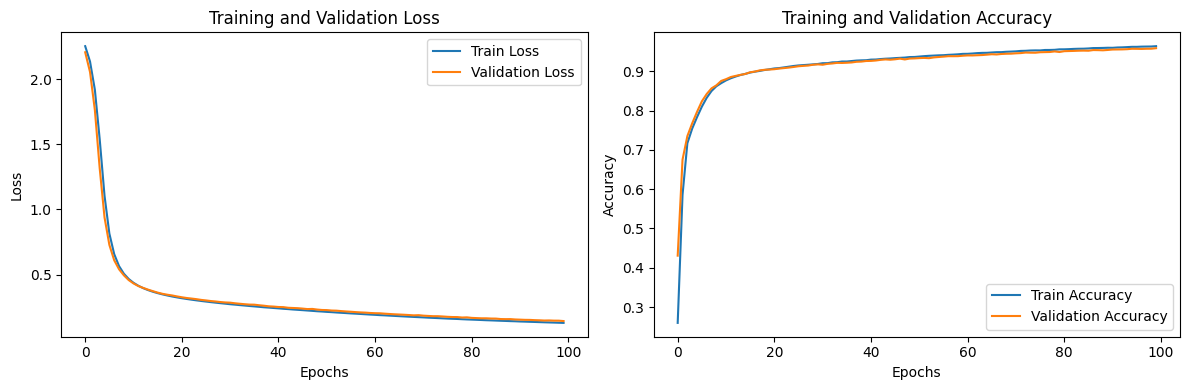

In [26]:
plot_training_history(train_loss_history, train_acc_history, 
                      valid_loss_history, valid_acc_history)

계속 결과가 좋아지는 양상을 보인다. 학습 갱신 속도를 조절하면 더 좋은 결과를 보일 수 있을 것 같다.

#### 3-2. Second Model

옵티마이저만 수정해서 진행해보자.

In [50]:
class MNIST_CNN(nn.Module):

    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # 첫번째층
        # Input = (?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # Input = (?, 14, 14, 32)
        # Conv -> (?, 14, 14, 64)
        # Pool -> (?, 7, 7, 64)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = nn.Linear(7 * 7 * 64, 10, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 1차원으로 Flatten
        out = self.fc(out)
        return out

In [51]:
# 모델 정의
model = MNIST_CNN()
model.to(device)

MNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [29]:
# 옵티마이저, 손실함수, 평가함수 정의
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)
acc_metric = Accuracy(task="multiclass", num_classes=10).to(device) # num_classes: 0~9

In [30]:
# 파라미터 정의
num_epochs = 50 # 굳이 많이 학습하는게 의미가 없을 것 같아서 줄임
wait_for_es = 5 # 조기 종료 발동을 완화함

In [31]:
# 모델 학습
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = model_training(model, 
                                                                                              train_dataloader, 
                                                                                              val_dataloader, 
                                                                                              criterion, 
                                                                                              optimizer, 
                                                                                              acc_metric, 
                                                                                              device, 
                                                                                              num_epochs, 
                                                                                              wait_for_es)

--------------------------------------------------------------------------------
Epoch 1/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.40it/s]


[Train]	 Loss: 0.3443 	 Acc: 0.8991
[Valid]	 Loss: 0.1210 	 Acc: 0.9633
(Epoch 1 complete in 0m 23s)
--------------------------------------------------------------------------------
Epoch 2/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.20it/s]


[Train]	 Loss: 0.0805 	 Acc: 0.9765
[Valid]	 Loss: 0.0755 	 Acc: 0.9765
(Epoch 2 complete in 0m 45s)
--------------------------------------------------------------------------------
Epoch 3/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.84it/s]


[Train]	 Loss: 0.0569 	 Acc: 0.9830
[Valid]	 Loss: 0.0645 	 Acc: 0.9804
(Epoch 3 complete in 1m 7s)
--------------------------------------------------------------------------------
Epoch 4/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.28it/s]


[Train]	 Loss: 0.0438 	 Acc: 0.9867
[Valid]	 Loss: 0.0654 	 Acc: 0.9807
(Epoch 4 complete in 1m 30s)
--------------------------------------------------------------------------------
Epoch 5/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 31.72it/s]


[Train]	 Loss: 0.0380 	 Acc: 0.9886
[Valid]	 Loss: 0.0545 	 Acc: 0.9835
(Epoch 5 complete in 1m 52s)
--------------------------------------------------------------------------------
Epoch 6/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.51it/s]


[Train]	 Loss: 0.0308 	 Acc: 0.9907
[Valid]	 Loss: 0.0566 	 Acc: 0.9840
(Epoch 6 complete in 2m 13s)
--------------------------------------------------------------------------------
Epoch 7/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.63it/s]


[Train]	 Loss: 0.0269 	 Acc: 0.9918
[Valid]	 Loss: 0.0484 	 Acc: 0.9858
(Epoch 7 complete in 2m 35s)
--------------------------------------------------------------------------------
Epoch 8/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.06it/s]


[Train]	 Loss: 0.0222 	 Acc: 0.9933
[Valid]	 Loss: 0.0526 	 Acc: 0.9850
(Epoch 8 complete in 2m 55s)
--------------------------------------------------------------------------------
Epoch 9/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 33.42it/s]


[Train]	 Loss: 0.0189 	 Acc: 0.9941
[Valid]	 Loss: 0.0509 	 Acc: 0.9850
(Epoch 9 complete in 3m 17s)
--------------------------------------------------------------------------------
Epoch 10/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 34.04it/s]

[Train]	 Loss: 0.0159 	 Acc: 0.9951
[Valid]	 Loss: 0.0530 	 Acc: 0.9858
(Epoch 10 complete in 3m 37s)
-----<Early Stopping at Epoch 10>-----


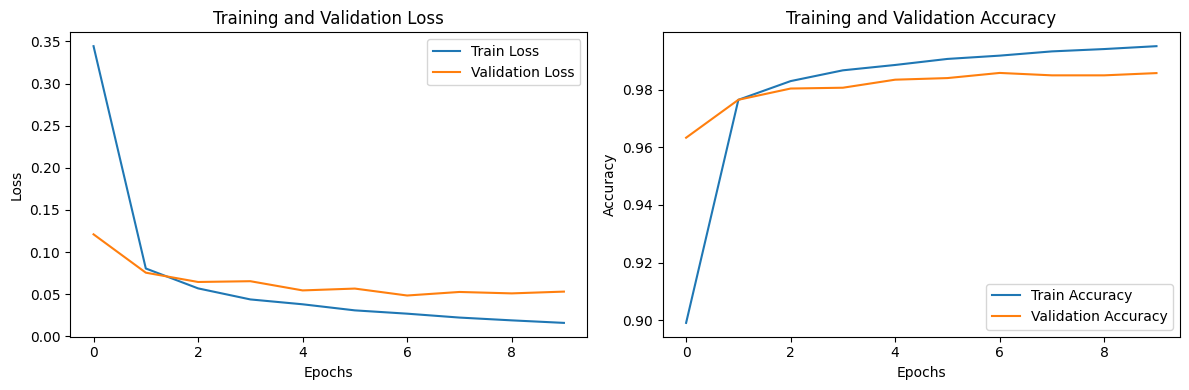

In [32]:
plot_training_history(train_loss_history, train_acc_history, 
                      valid_loss_history, valid_acc_history)

이번에는 Epoch 10에서 조기종료가 발동됐다.
- ```Adam``` 옵티마이저(학습률 0.001)가 최적의 파라미터로 더 빠르게 갱신하는 것 같다.
- 학습 조건을 동일하게 사용하여 새로운 모델을 사용해봐야겠다.

#### 3-3. Third Model

이번 모델은 과적합 방지를 위한 정규화 기법과 드롭아웃을 적용했다.

(사실 위에 모델이 충분히 잘 학습되었기 때문에 굳이 기법을 추가할 필요는 없어보이지만 시도😅)

In [13]:
class MNIST_CNN(nn.Module):

    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # 첫번째층
        # Input = (?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        # BatchNorm -> (?, 14, 14, 32)
        # Dropout : 0.25
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25))

        # 두번째층
        # Input = (?, 14, 14, 32)
        # Conv -> (?, 14, 14, 64)
        # Pool -> (?, 7, 7, 64)
        # BatchNorm -> (?, 7, 7, 64)
        # Dropout : 0.25
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25))

        # 첫번째 전결합층 
        # Input : 7x7x64 -> 10 outputs
        self.fc1 = nn.Linear(7 * 7 * 64, 10, bias=True)

        # 두번째 전결합층 
        # Input : 100 -> 10 outputs
        #self.fc2 = nn.Linear(100, 10, bias=True)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 1차원으로 Flatten
        out = self.fc1(out)
        return out

- 두번째 전결합층을 사용하면 파라미터가 30만개가 넘어버려서 없앴다.

In [14]:
model = MNIST_CNN().to(device)

In [15]:
# 모델 파라미터 개수 확인
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
           Dropout-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
       BatchNorm2d-9             [-1, 64, 7, 7]             128
          Dropout-10             [-1, 64, 7, 7]               0
           Linear-11                   [-1, 10]          31,370
Total params: 50,378
Trainable params: 50,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [17]:
# 옵티마이저, 손실함수, 평가함수 정의
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)
acc_metric = Accuracy(task="multiclass", num_classes=10).to(device) # num_classes: 0~9

In [61]:
# 하이퍼파라미터
num_epochs = 50
wait_for_es = 5

In [62]:
# 모델 학습
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = model_training(model, 
                                                                                              train_dataloader, 
                                                                                              val_dataloader, 
                                                                                              criterion, 
                                                                                              optimizer, 
                                                                                              acc_metric, 
                                                                                              device, 
                                                                                              num_epochs, 
                                                                                              wait_for_es)

--------------------------------------------------------------------------------
Epoch 1/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.25it/s]


[Train]	 Loss: 0.1749 	 Acc: 0.9462
[Valid]	 Loss: 0.0724 	 Acc: 0.9773
(Epoch 1 complete in 0m 24s)
--------------------------------------------------------------------------------
Epoch 2/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 31.76it/s]


[Train]	 Loss: 0.0666 	 Acc: 0.9794
[Valid]	 Loss: 0.0600 	 Acc: 0.9803
(Epoch 2 complete in 0m 46s)
--------------------------------------------------------------------------------
Epoch 3/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 29.55it/s]


[Train]	 Loss: 0.0524 	 Acc: 0.9835
[Valid]	 Loss: 0.0526 	 Acc: 0.9841
(Epoch 3 complete in 1m 9s)
--------------------------------------------------------------------------------
Epoch 4/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 32.34it/s]


[Train]	 Loss: 0.0439 	 Acc: 0.9862
[Valid]	 Loss: 0.0467 	 Acc: 0.9863
(Epoch 4 complete in 1m 33s)
--------------------------------------------------------------------------------
Epoch 5/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:05<00:00, 27.75it/s]


[Train]	 Loss: 0.0389 	 Acc: 0.9871
[Valid]	 Loss: 0.0438 	 Acc: 0.9873
(Epoch 5 complete in 1m 57s)
--------------------------------------------------------------------------------
Epoch 6/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:05<00:00, 25.42it/s]


[Train]	 Loss: 0.0364 	 Acc: 0.9884
[Valid]	 Loss: 0.0441 	 Acc: 0.9873
(Epoch 6 complete in 2m 23s)
--------------------------------------------------------------------------------
Epoch 7/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:05<00:00, 25.11it/s]


[Train]	 Loss: 0.0303 	 Acc: 0.9898
[Valid]	 Loss: 0.0507 	 Acc: 0.9856
(Epoch 7 complete in 2m 49s)
--------------------------------------------------------------------------------
Epoch 8/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 29.95it/s]


[Train]	 Loss: 0.0283 	 Acc: 0.9902
[Valid]	 Loss: 0.0456 	 Acc: 0.9867
(Epoch 8 complete in 3m 14s)
--------------------------------------------------------------------------------
Epoch 9/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:05<00:00, 27.39it/s]


[Train]	 Loss: 0.0275 	 Acc: 0.9913
[Valid]	 Loss: 0.0489 	 Acc: 0.9864
(Epoch 9 complete in 3m 39s)
--------------------------------------------------------------------------------
Epoch 10/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 140/140 [00:04<00:00, 30.82it/s]

[Train]	 Loss: 0.0237 	 Acc: 0.9924
[Valid]	 Loss: 0.0552 	 Acc: 0.9853
(Epoch 10 complete in 4m 4s)
-----<Early Stopping at Epoch 10>-----


역시나 Epoch 10에서 조기종료되었고, 최종 Accuracy는 약 98% 정도 된다. 성능이 더 좋아질까 싶었는데 정말 좋아졌다.

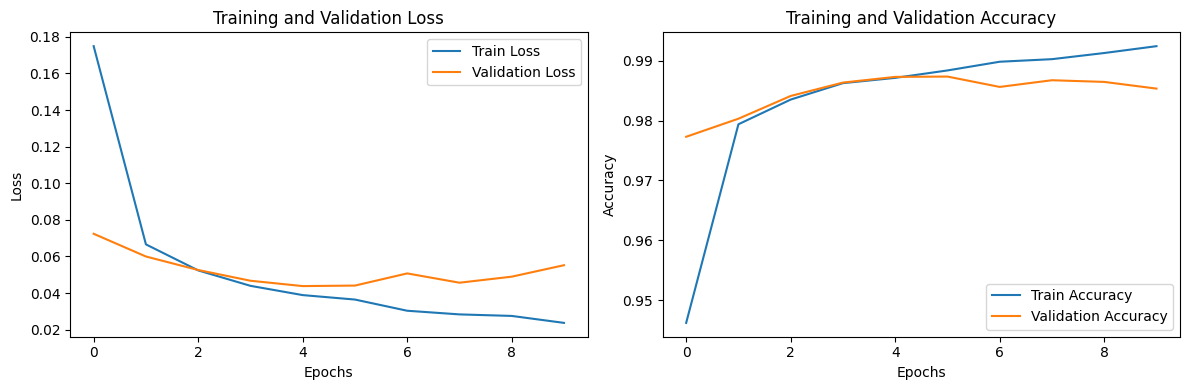

In [63]:
plot_training_history(train_loss_history, train_acc_history, 
                      valid_loss_history, valid_acc_history)

### 4. Evaluation

이제 Test 데이터로 모델의 성능을 평가해보자.

In [22]:
def eval_model(model, test_dataloader, device):
    # 학습하면서 저장한 모델 가져오기
    saved_model = glob.glob('C:/Python_Programs/Pytorch/6. MNIST/models/' + '*.pth')
    saved_model.sort()

    # 전체 accuracy 저장
    test_acc_history = []

    for model_path in saved_model:
        try: # 학습된 모델을 중복해서 저장했기 때문에 없는 경우는 넘어가도록 설정
            model.load_state_dict(torch.load(model_path))
            print('▶ Load Model :', model_path)
        except RuntimeError:
            continue
        model.to(device)
        model.eval()

        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)

            with torch.no_grad():  # Gradient 계산을 비활성화
                outputs = model(x)

        correct_prediction = torch.argmax(outputs, 1) == y
        accuracy = correct_prediction.float().mean()

        print('Model Accuracy : {:.4f}'.format(accuracy))
        test_acc_history.append(accuracy)

    return test_acc_history

In [23]:
test_acc_hist = eval_model(model, test_dataloader, device)

▶ Load Model : C:/Python_Programs/Pytorch/6. MNIST/models\MNIST_CNN1.pth
Model Accuracy : 0.9922
▶ Load Model : C:/Python_Programs/Pytorch/6. MNIST/models\MNIST_CNN2.pth
Model Accuracy : 0.9922
▶ Load Model : C:/Python_Programs/Pytorch/6. MNIST/models\MNIST_CNN3.pth
Model Accuracy : 0.9844
▶ Load Model : C:/Python_Programs/Pytorch/6. MNIST/models\MNIST_CNN4.pth
Model Accuracy : 1.0000
▶ Load Model : C:/Python_Programs/Pytorch/6. MNIST/models\MNIST_CNN5.pth
Model Accuracy : 0.9922
▶ Load Model : C:/Python_Programs/Pytorch/6. MNIST/models\MNIST_CNN6.pth
Model Accuracy : 0.9922


테스트 데이터에 대한 Inference와 정확도 확인까지 해봤다. 정확도가 100%인 경우까지 있는게 신기하다.